In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
%matplotlib inline

In [4]:
df= pd.read_csv("american_train_dataset.csv")
df.columns = [i for i in range(df.shape[1])]
df = df.rename(columns={42: 'Output'})

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,Output
0,0.710651,0.360695,0.615888,0.346171,0.550860,0.282601,0.534762,0.218653,0.534387,0.164782,...,0.294588,0.770108,0.201429,0.770906,0.183164,0.770106,0.239929,0.771767,0.288998,A
1,0.405695,0.647552,0.319726,0.581067,0.271913,0.498254,0.273852,0.422791,0.295577,0.365717,...,0.546457,0.500247,0.503992,0.491320,0.457143,0.470195,0.505762,0.454539,0.552650,A
2,0.316689,0.521771,0.232337,0.467040,0.177462,0.386787,0.160568,0.317913,0.168354,0.258710,...,0.429866,0.397665,0.363233,0.370970,0.322016,0.361503,0.368900,0.359597,0.413843,A
3,0.548107,0.650610,0.476015,0.570932,0.428442,0.476566,0.431988,0.391317,0.477113,0.336531,...,0.536890,0.672368,0.509499,0.671439,0.455122,0.642028,0.502216,0.620230,0.548037,A
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,A


In [6]:
df.shape

(83999, 43)

In [7]:
# removemos los datos nulos del dataset
all_null_values = df[df.iloc[:, 0] == 0]
print("Cantidad de valores nulos: ", len(all_null_values.index))

Cantidad de valores nulos:  24290


In [8]:
# eliminamos los datos nulos
df = df.drop(all_null_values.index)
df.shape

(59709, 43)

In [9]:
# Asignamos los valores de X (42 puntos de la mano) y Y (letra)
X = df.iloc[:, :-1]
print("Tamaño de las características: ", X.shape)
y = df.iloc[:, -1]
print("Tamaño de las etiquetas: ", y.shape)

Tamaño de las características:  (59709, 42)
Tamaño de las etiquetas:  (59709,)


In [11]:
# separamos en conjunto de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
from sklearn.preprocessing import LabelBinarizer
# convertimos las etiquetas a números 
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [20]:
# creamos el modelo de red neuronal para clasificar las letras
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(42,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(28, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               5504      
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 28)                924       
                                                                 
Total params: 16,764
Trainable params: 16,764
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test), callbacks=[learning_rate_reduction])

Epoch 1/20


2022-11-27 20:26:13.065284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1493/1493 [==============================] - ETA: 0s - loss: 0.9877 - accuracy: 0.7285

2022-11-27 20:26:28.755773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1493/1493 [==============================] - 19s 12ms/step - loss: 0.9877 - accuracy: 0.7285 - val_loss: 0.3635 - val_accuracy: 0.8822 - lr: 0.0010
Epoch 2/20
1493/1493 [==============================] - 19s 12ms/step - loss: 0.3072 - accuracy: 0.9105 - val_loss: 0.2205 - val_accuracy: 0.9504 - lr: 0.0010
Epoch 3/20
1493/1493 [==============================] - 19s 13ms/step - loss: 0.2068 - accuracy: 0.9454 - val_loss: 0.1992 - val_accuracy: 0.9339 - lr: 0.0010
Epoch 4/20
1493/1493 [==============================] - 19s 13ms/step - loss: 0.1509 - accuracy: 0.9646 - val_loss: 0.1265 - val_accuracy: 0.9736 - lr: 0.0010
Epoch 5/20
1493/1493 [==============================] - 20s 14ms/step - loss: 0.1260 - accuracy: 0.9700 - val_loss: 0.1234 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 6/20
1493/1493 [==============================] - 18s 12ms/step - loss: 0.1188 - accuracy: 0.9723 - val_loss: 0.0999 - val_accuracy: 0.9791 - lr: 0.0010
Epoch 7/20
1493/1493 [==============================] - 1

374/374 [==============================] - 1s 3ms/step


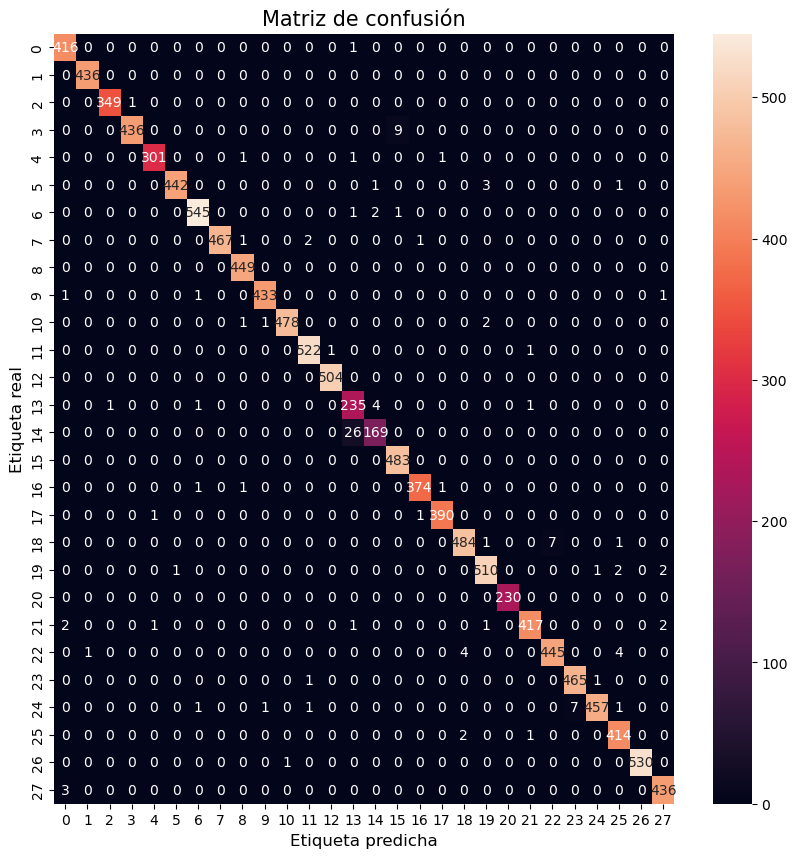

In [56]:
# matriz de confusión para el conjunto de prueba
import seaborn as sns
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Matriz de confusión', fontsize=15)
plt.ylabel('Etiqueta real', fontsize=12)
plt.xlabel('Etiqueta predicha', fontsize=12)
plt.show()


In [23]:
# A continuacion, tenemos que crear un archivo de etiquetas que contendra todas nuestras etiquetas (importante para Flutter)
labels = '\n'.join(sorted(df['Output'].unique())) 
with open('labels.txt', 'w') as f: # escribe en el archivo labels.txt, y si no existe, lo crea, y si existe, lo sobreescribe. (eso es lo que 'w' es para)
    f.write(labels)

In [24]:
# con nuestra red neuronal entrenada con tensorflow y keras, podemos exportarla
saved_model_dir = '' # directorio donde se guardara el modelo
tf.saved_model.save(model, saved_model_dir) # guarda el modelo en el directorio

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
tflite_model = converter.convert() # convierte el modelo en un modelo de tensorflow lite, que pueda usar flutter 
with open('model.tflite', 'wb') as f: # guardamos el modelo en un archivo llamado model.tflite, y si no existe, lo crea, y si existe, lo sobreescribe. (eso es lo que 'wb' es para)
  f.write(tflite_model)

INFO:tensorflow:Assets written to: assets
INFO:tensorflow:Assets written to: /var/folders/w9/47hfrj5s20n22dxytnnn2mjh0000gn/T/tmp_hambkdp/assets


2022-11-27 20:33:06.092756: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-27 20:33:06.092774: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-27 20:33:06.093274: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/w9/47hfrj5s20n22dxytnnn2mjh0000gn/T/tmp_hambkdp
2022-11-27 20:33:06.094158: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-27 20:33:06.094170: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/w9/47hfrj5s20n22dxytnnn2mjh0000gn/T/tmp_hambkdp
2022-11-27 20:33:06.096518: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-11-27 20:33:06.097341: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-27 20:33:06.135250: I tensorflow/cc/saved_model/loader.

In [30]:
# Cargamos el modelo
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Obtenemos las entradas y salidas del modelo
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [47]:
import cv2 
import mediapipe as mp
def image_processed(hand_img):
    # 1. Convertir a RGB
    img_rgb = cv2.cvtColor(hand_img, cv2.COLOR_BGR2RGB)
    # 2. Dar la vuelta a la imagen
    img_flip = cv2.flip(img_rgb, 1)
    # 3. Mediapipe
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True,
                           max_num_hands=2, min_detection_confidence=0.7)
    output = hands.process(img_flip)
    hands.close()

    # Extraemos la información de las manos
    try:
        data = output.multi_hand_landmarks[0]
        data = str(data)
        data = data.strip().split('\n')
        garbage = ['landmark {', '  visibility: 0.0', '  presence: 0.0', '}']

        # Eliminamos los datos basura
        without_garbage = []
        for i in data:
            if i not in garbage:
                without_garbage.append(i)

        # Extraemos los datos de forma numérica
        clean = []
        for i in without_garbage:
            i = i.strip()
            clean.append(i[2:])

        # Eliminamos el eje z
        finalClean = []
        for i in range(0, len(clean)):
            if (i+1) % 3 != 0:
                finalClean.append(float(clean[i]))
        return finalClean
    # Si no detecta ninguna mano, devuelve un array de ceros
    except:
        return(np.zeros([1, 42], dtype=int)[0])


In [83]:
img = cv2.imread('dataset/Test/Z/3001.jpg')
hand_array = image_processed(img)
# print (hand_array)
hand_array = np.array(hand_array).reshape(1, 42)

# Predecimos
input_shape = input_details[0]['shape']
input_data = np.array(hand_array)

interpreter.set_tensor(input_details[0]['index'], input_data.astype(np.float32)) 
interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
results = np.squeeze(output_data)

# Mostramos el resultado
top_k = results.argsort()[-5:][::-1]
labels = open('labels.txt').read().splitlines()
for i in top_k:
    print(labels[i], results[i])

Z 0.8557944
M 0.09340868
K 0.044117328
L 0.0048716655
V 0.0014825299
